# Tutorial on Imaging Mass Cytometry data 

In this tutorial we will showcase how ATHENA can be used to explore Imaging Mass Cytometry datasets. We will use the publicly available dataset of (Jackson et al., 2020 - [paper](https://www.nature.com/articles/s41586-019-1876-x)), where the authors used a panel of 35 cancer and immune markers to spatially profile the breast cancer ecosystem using Tissue Microarrays (TMAs) from two cohorts of breast cancer patients. 


## Import needed packages

In [1]:
import spatialHeterogeneity as sh
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize
import seaborn as sns

pd.set_option('display.max_columns', 5)

## Load IMC data into a `SpatialOmics` object
Although the dataset consists of a total of 720 tumor images from 352 patients with breast cancer, for this tutorial, we will import 8 random TMA cores that can be easily loaded using the `.dataset` module of `SpatialHeterogeneity`:

In [2]:
so = sh.dataset.imc()
so

INFO:numexpr.utils:NumExpr defaulting to 8 threads.



SpatialOmics object with n_obs 20674
    X: 8, (1369, 6069) x (34, 34)
    spl: 8, ['pid', 'grade', 'location', 'tumor_size', 'gender', 'age', 'disease_status', 'ER_status', 'PR_status', 'filename_fullstack', 'height', 'width', 'area', 'subtype', 'clinical_type', 'cohort']
    obs: 8, {'cell_type_id', 'meta_label', 'cell_type', 'meta_id'}
    var: 8, {'metal_tag', 'fullstack_index', 'feature_type', 'target', 'channel', 'full_target_name'}
    G: 8, {'contact'}
    masks: 8, {'cellmasks', 'tumor_stroma'}
    images: 8

## Explore `SpatialOmics` object

Various preprocessing steps (segmentation, single-cell quantification, phenotyping) have been applied to the data by the original authors and are included in the various attributes of the data. For example, `so.spl` contains sample-level metadata:

In [3]:
print(so.spl.columns.values) #see all available sample annotations
so.spl.head(3) 

['pid' 'grade' 'location' 'tumor_size' 'gender' 'age' 'disease_status'
 'ER_status' 'PR_status' 'filename_fullstack' 'height' 'width' 'area'
 'subtype' 'clinical_type' 'cohort']


pid  grade  ... clinical_type  cohort
core                        ...                      
SP43_116_X3Y4   116      3  ...     TripleNeg   Basel
slide_49_By2x5   49      2  ...      HR+HER2-       Z
slide_59_Cy7x7   59      3  ...     TripleNeg       Z

[3 rows x 16 columns]

... and `so.obs` contains all single-cell level metadata:

In [4]:
spl = 'slide_49_By2x5' #for one specific sample
print(so.obs[spl].columns.values) #see all available sample annotations
so.obs[spl].head(3) 

['meta_id' 'meta_label' 'cell_type_id' 'cell_type']


meta_id       meta_label cell_type_id cell_type
cell_id                                                
1            11   Fibronectin Hi            3   stromal
2            13  SMA Hi Vimentin            3   stromal
3            13  SMA Hi Vimentin            3   stromal

The `so.mask` attribute contains for each sample different segmentation masks. For this data set we have access to two different segmentations for each sample, the segmentation into single cells (`cellmasks`) and the segmentation into tumor-stroma regions (`tumor_stroma`). 

In [5]:
print(so.masks[spl].keys())

dict_keys(['cellmasks', 'tumor_stroma'])


## Visualize raw images and masks
Run the cell below to launch the interactive [napari](https://napari.org) viewer and explore the multiplexed raw images. In addition to the single protein expression levels, we also add segmentations masks (with `add_masks`) for both the single-cell and the tumor-stroma borders.

In [6]:
sh.pl.napari_viewer(so, spl, attrs=so.var[spl]['target'], add_masks=so.masks[spl].keys())

INFO:OpenGL.acceleratesupport:No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'


## Visualize single-cell data

### Set colormaps
First, let us set up a colormap and save it in the `.uns` attribute of the `SpatialOmics` instance, where it will be accessed by the `.pl` submodules when plotting certain features of the data. If no colormap is defined, the `.pl` module uses the ```default``` colormap (`so.uns['colormap']['default']`). The loaded dataset already comes with a phenotype classification for each single cell (`meta_id` in `.obs`) and a more coarse classification into main cell types (`cell_type_id` in `.obs`).

In [7]:
# define default colormap
so.uns['cmaps'].update({'default': cm.Reds})

# set up colormaps for meta_id
cmap_paper = np.array([[255, 255, 255], [10, 141, 66], [62, 181, 86], [203, 224, 87],  # 0 1 2 3
                       [84, 108, 47], [180, 212, 50], [23, 101, 54],  # 4 5 6
                       [248, 232, 13], [1, 247, 252], [190, 252, 252],  # 7 8 9
                       [150, 210, 225], [151, 254, 255], [0, 255, 250],  # 10 11 12
                       [154, 244, 253], [19, 76, 144], [0, 2, 251],  # 13 14 15
                       [147, 213, 198], [67, 140, 114], [238, 70, 71],  # 16 17 18
                       [80, 45, 143], [135, 76, 158], [250, 179, 195],  # 19 20 21
                       [246, 108, 179], [207, 103, 43], [224, 162, 2],  # 22 23 24
                       [246, 131, 110], [135, 92, 43], [178, 33, 28]])


# define labels for meta_id
cmap_labels = {0: 'Background',
               1: 'B cells',
               2: 'B and T cells',
               3: 'T cell',
               4: 'Macrophages',
               5: 'T cell',
               6: 'Macrophages',
               7: 'Endothelial',
               8: 'Vimentin Hi',
               9: 'Small circular',
               10: 'Small elongated',
               11: 'Fibronectin Hi',
               12: 'Larger elongated',
               13: 'SMA Hi Vimentin',
               14: 'Hypoxic',
               15: 'Apopotic',
               16: 'Proliferative',
               17: 'p53 EGFR', 
               18: 'Basal CK',
               19: 'CK7 CK hi Cadherin',
               20: 'CK7 CK',
               21: 'Epithelial low',
               22: 'CK low HR low',                            
               23: 'HR hi CK',               
               24: 'CK HR', 
               25: 'HR low CK',                             
               27: 'Myoepithalial',
               26: 'CK low HR hi p53'}

so.uns['cmaps'].update({'meta_id': ListedColormap(cmap_paper / 255)})
so.uns['cmap_labels'].update({'meta_id': cmap_labels})

# cell_type_id colormap
cmap = ['white', 'darkgreen', 'gold', 'steelblue', 'darkred', 'coral']
cmap_labels = {0: 'background', 1: 'immune',  2: 'endothelial', 3: 'stromal', 4: 'tumor', 5: 'myoepithelial'}
cmap = ListedColormap(cmap)

so.uns['cmaps'].update({'cell_type_id': cmap})
so.uns['cmap_labels'].update({'cell_type_id': cmap_labels})

### Plot protein intensity or single-cell annotations 

Samples stored in the `SpatialOmics` object can be visualised with the plotting function `pl.spatial`.
In a first step we extract the centroids of each cell segmentation masks with `pp.extract_centroids` and store the results in the `SpatialOmics` instance (`so.obs[spl]`). This is required to enable the full plotting functionalities.

In [8]:
print(so.masks[spl].keys())

# extract cell centroids across all samples
for spl in so.obs.keys():
    sh.pp.extract_centroids(so, spl, mask_key='cellmasks')

# print results
print(so.obs[spl])

dict_keys(['cellmasks', 'tumor_stroma'])
        meta_id          meta_label  ...           y           x
cell_id                              ...                        
1            19  CK7 CK hi Cadherin  ...   11.344660   72.325243
2            20              CK7 CK  ...    2.346154   85.961538
3            19  CK7 CK hi Cadherin  ...    1.142857  209.809524
4            19  CK7 CK hi Cadherin  ...    3.769912  219.769912
5            14             Hypoxic  ...    1.375000  260.166667
...         ...                 ...  ...         ...         ...
1611          7         Endothelial  ...  518.425000  192.075000
1612         19  CK7 CK hi Cadherin  ...  518.477612  233.283582
1613         19  CK7 CK hi Cadherin  ...  520.000000  413.956522
1614         19  CK7 CK hi Cadherin  ...  519.962963  421.962963
1615         11      Fibronectin Hi  ...  514.229167  507.343750

[1611 rows x 6 columns]


If only the `SpatialOmics` instance and the sample id is provided, the sample is plotted as a scatter plot using the computed centroids. However, with `mode=mask`, the computed segmentation masks are used. The observations can be colored according to a specific feature from `so.obs[spl]` or `so.X[spl]` - see example below:

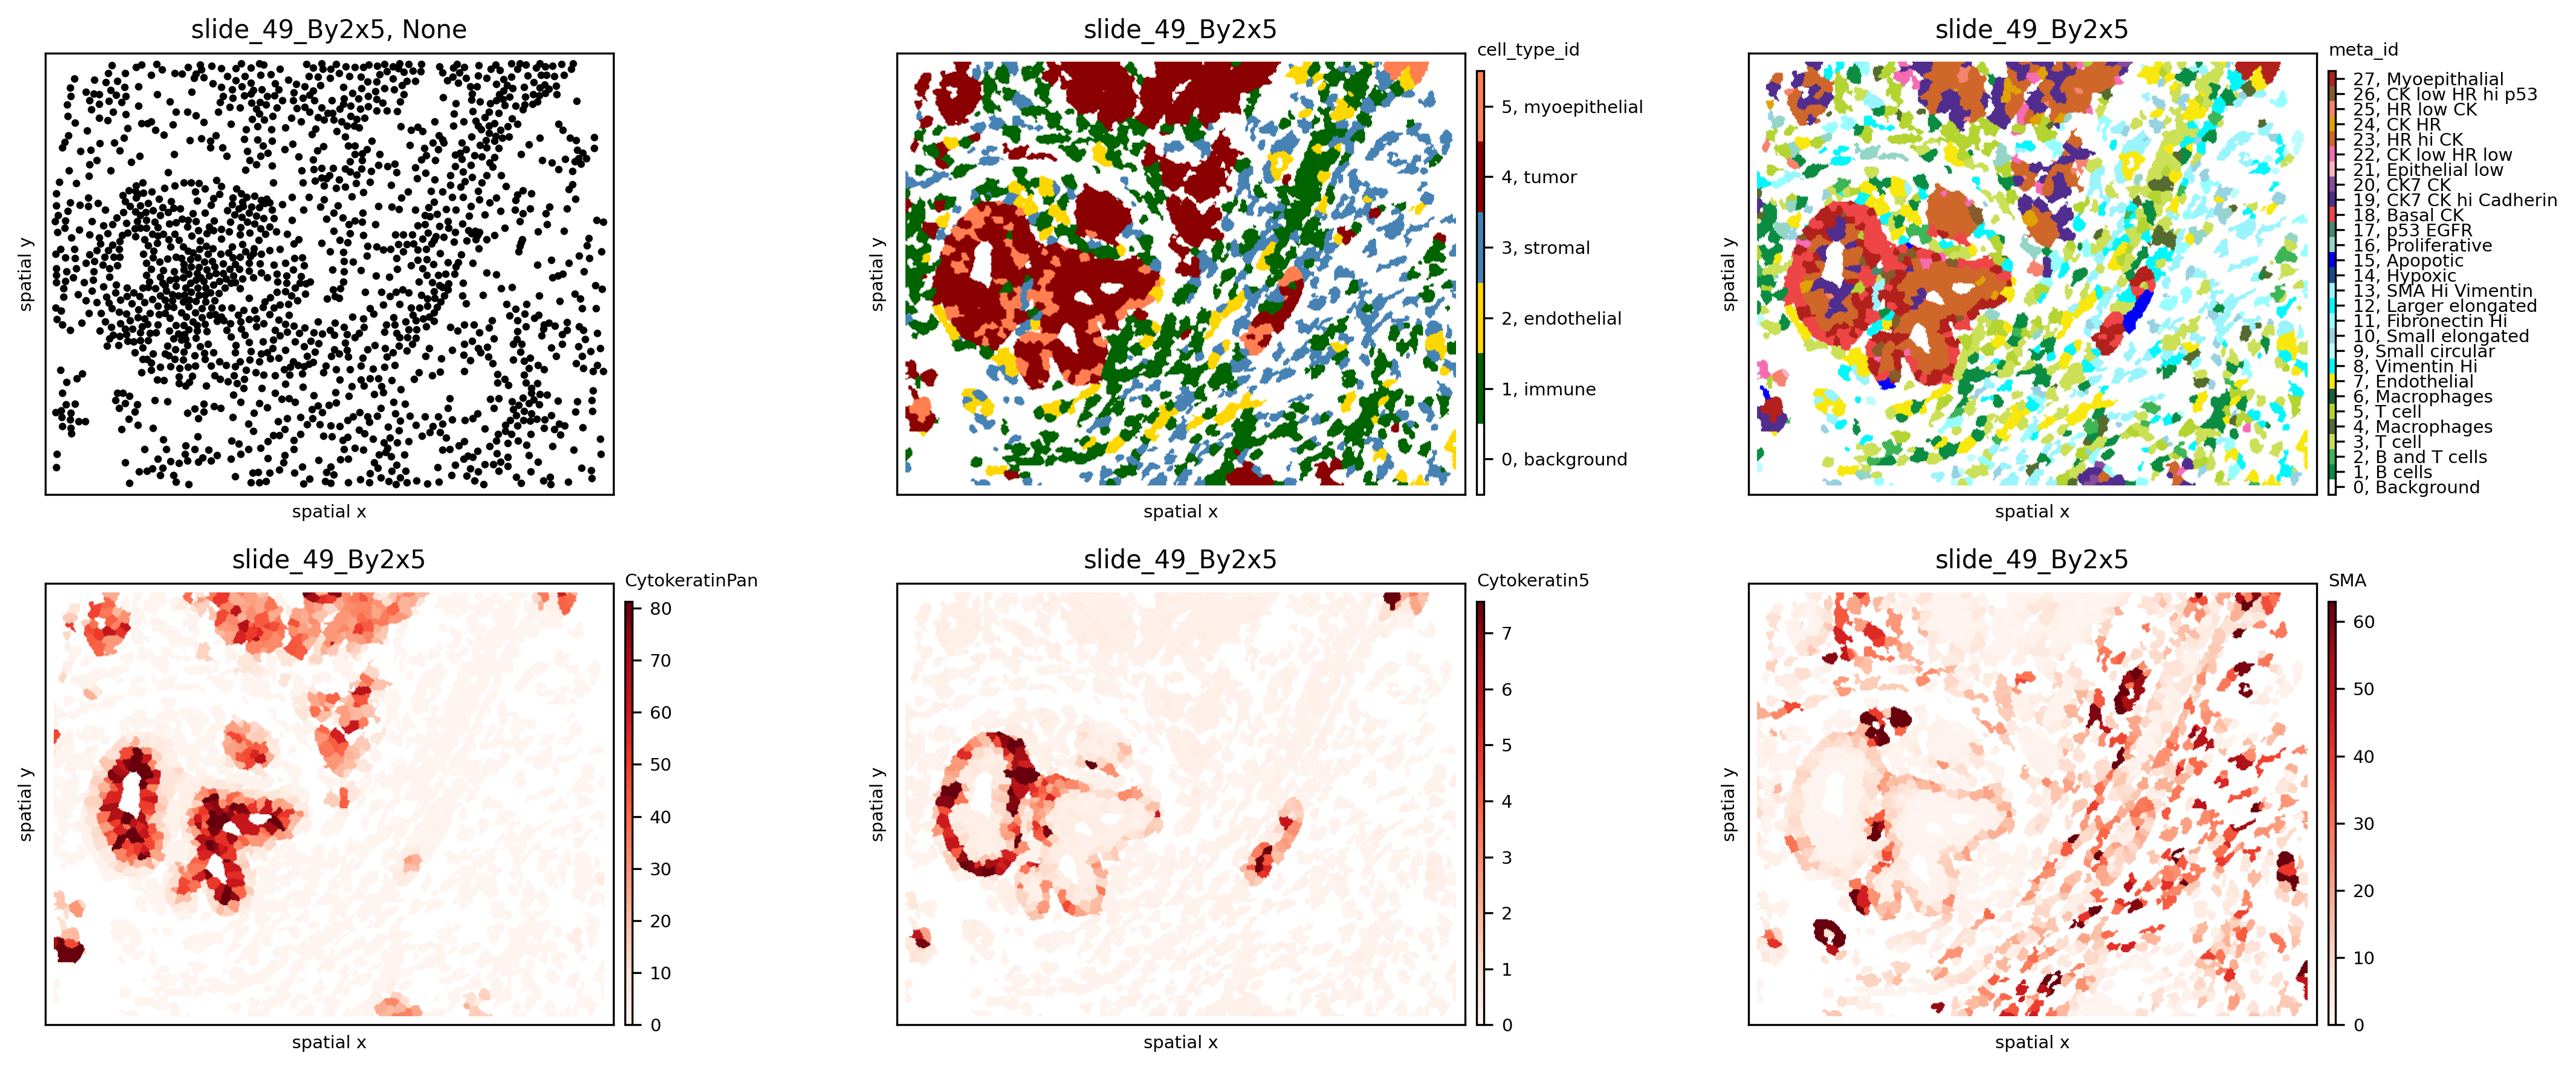

In [9]:
spl = 'slide_49_By2x5'
fig, axs = plt.subplots(2, 3, figsize=(15, 6), dpi=300)
sh.pl.spatial(so, spl, None, ax=axs.flat[0])
sh.pl.spatial(so, spl, 'cell_type_id', mode='mask', ax=axs.flat[1])
sh.pl.spatial(so, spl, 'meta_id', mode='mask', ax=axs.flat[2])
sh.pl.spatial(so, spl, 'CytokeratinPan', mode='mask', ax=axs.flat[3])
sh.pl.spatial(so, spl, 'Cytokeratin5', mode='mask', ax=axs.flat[4])
sh.pl.spatial(so, spl, 'SMA', mode='mask', ax=axs.flat[5])

Experiment with different colormaps or background colors:

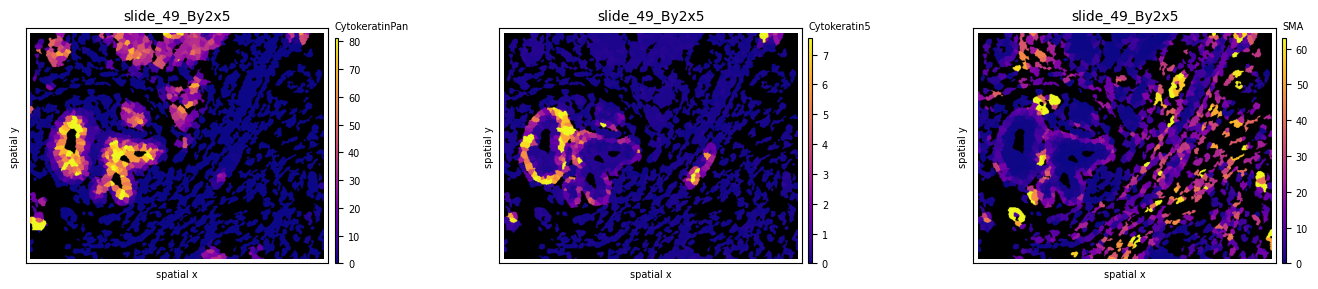

In [10]:
so.uns['cmaps'].update({'default': cm.plasma})
fig, axs = plt.subplots(1, 3, figsize=(15, 3), dpi=100)
sh.pl.spatial(so, spl, 'CytokeratinPan', mode='mask', ax=axs.flat[0], background_color='black')
sh.pl.spatial(so, spl, 'Cytokeratin5', mode='mask', ax=axs.flat[1], background_color='black')
sh.pl.spatial(so, spl, 'SMA', mode='mask', ax=axs.flat[2], background_color='black')

## Graph construction
Use the `.graph` submodule to construct 3 different graphs and experiment with the parameters (k, radius):

In [11]:
# import default graph builder parameters
from spatialHeterogeneity.graph_builder.constants import GRAPH_BUILDER_DEFAULT_PARAMS

# kNN graph
config = GRAPH_BUILDER_DEFAULT_PARAMS['knn']
config['builder_params']['n_neighbors'] = 6 # set parameter k
sh.graph.build_graph(so, spl, builder_type='knn', mask_key='cellmasks', config=config)

# radius graph
config = GRAPH_BUILDER_DEFAULT_PARAMS['radius']
config['builder_params']['radius'] = 20 # set radius
sh.graph.build_graph(so, spl, builder_type='radius', mask_key='cellmasks', config=config)

# contact graph - this takes some time
sh.graph.build_graph(so, spl, builder_type='contact', mask_key='cellmasks')

# the results are saved back into `.G`:
so.G[spl]

/usr/local/Caskroom/miniconda/base/envs/athena/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/athena/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████████████| 1541/1541 [00:16<00:00, 92.62it/s]


{'contact': <networkx.classes.graph.Graph at 0x7fc4c269e0d0>,
 'knn': <networkx.classes.graph.Graph at 0x7fc4954375e0>,
 'radius': <networkx.classes.graph.Graph at 0x7fc495605070>}

The results can be plotted again using the `.pl.spatial` submodule. Notice how different graph builders result in graphs with different properties:

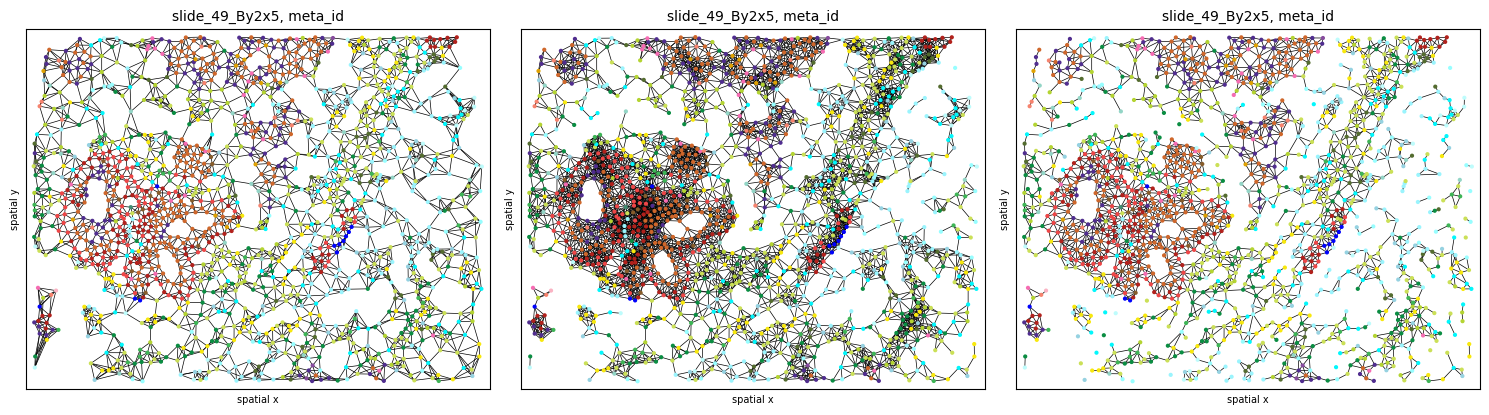

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6), dpi=100)
sh.pl.spatial(so, spl, 'meta_id', edges=True, graph_key='knn', ax=axs.flat[0], cbar=False)
sh.pl.spatial(so, spl, 'meta_id', edges=True, graph_key='radius', ax=axs.flat[1], cbar=False)
sh.pl.spatial(so, spl, 'meta_id', edges=True, graph_key='contact', ax=axs.flat[2], cbar=False)

## Heterogeneity quantification

### Sample-level scores
Sample-level scores estimate a single heterogeneity score for the whole tumor, saved in `so.spl`. Although they ignore the spatial topology and cell-cell interactions, they describe the heterogeneity attrbuted to the number of cell types present and their frequencies. Below we show how to compute some of the included metrics across all 8 samples:

In [13]:
# compute cell counts
so.spl['cell_count'] = [len(so.obs[s]) for s in so.obs.keys()]
so.spl['immune_cell_count'] = [np.sum(so.obs[s].cell_type == 'immune') for s in so.obs.keys()]

# compute metrics at a sample level
all_samples = so.spl.index.values
for s in all_samples:
    sh.metrics.richness(so, s, 'meta_id', local=False)
    sh.metrics.shannon(so, s, 'meta_id', local=False)

# estimated values are saved in so.spl    
so.spl[['cell_count', 'richness_meta_id', 'shannon_meta_id']]

cell_count  richness_meta_id  shannon_meta_id
core                                                         
SP43_116_X3Y4         6069              25.0         3.176066
slide_49_By2x5        1541              24.0         3.952585
slide_59_Cy7x7        2792              15.0         2.794546
slide_59_Cy7x8        2856              14.0         2.222783
slide_59_Cy8x1        2701              15.0         2.796984
slide_7_Cy2x2         1735              19.0         3.410451
slide_7_Cy2x3         1369              18.0         3.202213
slide_7_Cy2x4         1611              21.0         1.951253

To evaluate results, let's look at two samples (`slide_7_Cy2x2` and `slide_7_Cy2x4`) from the same patient (`pid`=7). Although they have similar cell counts and richness, their Shannon entropy values are markedly different, indicating higher heterogeneity for sample `slide_7_Cy2x2`:

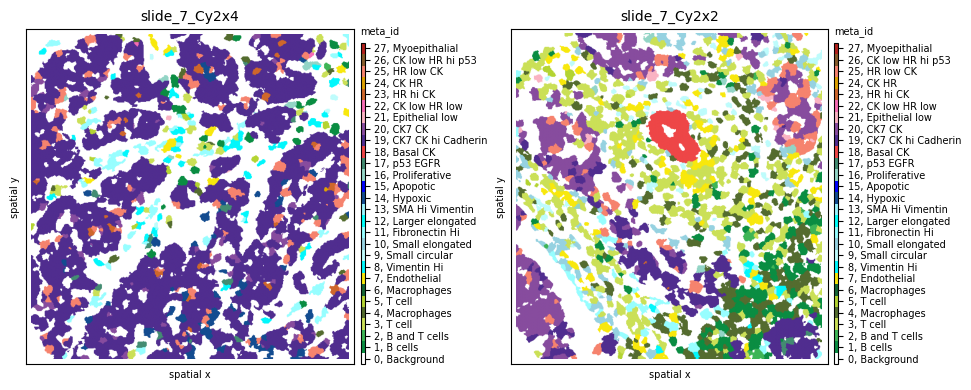

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=100)
sh.pl.spatial(so, 'slide_7_Cy2x4', 'meta_id', mode='mask', ax=axs.flat[0])
sh.pl.spatial(so, 'slide_7_Cy2x2', 'meta_id', mode='mask', ax=axs.flat[1])

Indeed, we clearly see that while the first sample is dominated by one cell subpopulation (`CK7 CK hi Cadherin`), in the second sample the `meta_id` distribution is more spread, resulting in a higher Shannon index.

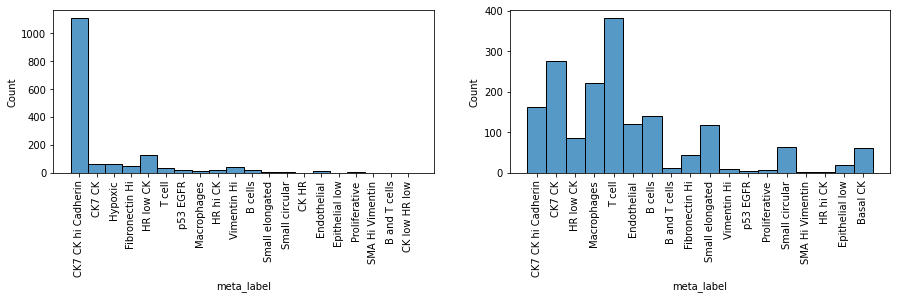

In [15]:
fig = plt.figure(figsize=(15, 3))
plt.subplot(1, 2, 1)
sns.histplot(so.obs['slide_7_Cy2x4']['meta_label'])
plt.xticks(rotation=90)
plt.subplot(1, 2, 2)
sns.histplot(so.obs['slide_7_Cy2x2']['meta_label'])
plt.xticks(rotation=90)
plt.show()

### Cell-level scores
Cell-level scores quantify heterogeneity in a spatial manner, accounting for local effects, and return a value per single cell, saved in `so.obs`. To apply these scores to the data we use again `.metrics` but this time with `local=True`.  Since these scores heavily depend on the tumor topology, the graph type and occasionally additional parameters also need to be provided.

In [ ]:
# compute metrics at a cell level for all samples - this will take some time
for s in tqdm(all_samples):
    sh.metrics.richness(so, s, 'meta_id', local=True, graph_key='contact')
    sh.metrics.shannon(so, s, 'meta_id', local=True, graph_key='contact')
    sh.metrics.quadratic_entropy(so, s, 'meta_id', local=True, graph_key='contact', metric='cosine')

# estimated values are saved in so.obs
so.obs[spl].columns

  0%|                                                                                         | 0/8 [00:00<?, ?it/s]

The results can be plotted again using the `.pl.spatial` submodule and passing the attribute we want to visualize. For example, let's observe the spatial heterogeneity of a random sample using three different metrics in the cell below. While local richness highlights tumor neighborhoods with multiple cell phenotypes present, local Shannon  also takes into consideration the proportions of these phenotypes. Finally, local quadratic entropy additionally takes into consideration the similarity between these phenotypes using the single-cell proteomic data stored in `.X`. Notice how, in the last subplot, only regions where cell phenotypes with very different profiles (e.g., tumor - immune - stromal) are highlighted.

In [ ]:
so.uns['cmaps'].update({'default': cm.plasma})

# visualize cell-level scores
spl='slide_49_By2x5'
fig, axs = plt.subplots(1, 4, figsize=(25, 12), dpi=300)
axs = axs.flat
sh.pl.spatial(so, spl, 'meta_id', mode='mask', ax=axs[0])
sh.pl.spatial(so, spl, 'richness_meta_id_contact', mode='mask', ax=axs[1], cbar_title=False, background_color='black')
sh.pl.spatial(so, spl, 'shannon_meta_id_contact', mode='mask', ax=axs[2], cbar_title=False, background_color='black')
sh.pl.spatial(so, spl, 'quadratic_meta_id_contact', mode='mask', ax=axs[3], cbar_title=False, background_color='black')

We can also observe how different graph topologies strongly influence the results:

In [ ]:
so.uns['cmaps'].update({'default': cm.plasma})

# try out different graph topologies
sh.metrics.quadratic_entropy(so, spl, 'meta_id', local=True, graph_key='radius')
sh.metrics.quadratic_entropy(so, spl, 'meta_id', local=True, graph_key='knn')

# visualize results
fig, axs = plt.subplots(1, 4, figsize=(25, 12), dpi=300)
axs = axs.flat
sh.pl.spatial(so, spl, 'meta_id', mode='mask', ax=axs[0])
sh.pl.spatial(so, spl, 'quadratic_meta_id_contact', mode='mask', ax=axs[1], cbar_title=False, background_color='black')
sh.pl.spatial(so, spl, 'quadratic_meta_id_radius', mode='mask', ax=axs[2], cbar_title=False, background_color='black')
sh.pl.spatial(so, spl, 'quadratic_meta_id_knn', mode='mask', ax=axs[3], cbar_title=False, background_color='black')

Since these scores are computed at the single-cell level, each tumor can now be represented by a *histogram* of values, as seen below for local quadratic entropy:

In [ ]:
fig = plt.figure(figsize=(25, 12))
for i,s in enumerate(all_samples):
    plt.subplot(2, 4, i+1)
    g=sns.histplot(so.obs[s]['quadratic_meta_id_contact'], stat='probability')
    g.set_title(s + ', median quad entropy = ' + str(round(so.obs[s]['quadratic_meta_id_contact'].median(),3)))
    plt.ylim([0,0.32])
    plt.xlim([0,1])

Let's plot two of the samples with the smallest and highest median quadratic entropy to evaluate the results. We clearly see that `slide_7_Cy2x4` is mostly homogeneous, with few highly entropic regions, and `slide_59_Cy7x7` is highly heterogeneous, as most areas contain mixtures of immune, stromal, endothelial and cancer cells. 

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(20, 8), dpi=100)
sh.pl.spatial(so, 'slide_7_Cy2x4', 'meta_id', mode='mask', ax=axs.flat[0])
sh.pl.spatial(so, 'slide_7_Cy2x4', 'quadratic_meta_id_contact', mode='mask', ax=axs.flat[1], 
              cbar=False, background_color='black')
sh.pl.spatial(so, 'slide_59_Cy7x7', 'meta_id', mode='mask', ax=axs.flat[2])
sh.pl.spatial(so, 'slide_59_Cy7x7', 'quadratic_meta_id_contact', mode='mask', ax=axs.flat[3], 
              cbar=False, background_color='black')


In [ ]:
# if needed, we can retrieve selected single-cell score values 
so.obs[spl].loc[:,['richness_meta_id_contact',
                   'shannon_meta_id_contact',
                   'quadratic_meta_id_contact']].head(5)

### Immune infiltration
The infiltration score included in the `.neigh` submodule quantifies the degree of tumor-immune mixing (as defined in Keren, L. et al. - [paper](https://www.cell.com/cell/fulltext/S0092-8674(18)31100-0?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0092867418311000%3Fshowall%3Dtrue)). Let us compute it across all patients:

In [ ]:
for s in tqdm(all_samples):
    sh.neigh.infiltration(so, s, 'cell_type', graph_key='contact')

so.spl.loc[all_samples].infiltration

Now let's sort all samples by increasing immune infiltration:

In [ ]:
# sort samples by increasing infiltration
ind1=np.argsort(so.spl.loc[all_samples].infiltration.values)

# update colormap to show only immune and tumor cells 
cmap = ['white', 'darkgreen', 'lightgrey', 'lightgrey', 'darkred', 'lightgrey']
cmap_labels = {0: 'background', 1: 'immune',  2: 'endothelial', 3: 'stromal', 4: 'tumor', 5: 'myoepithelial'}
cmap = ListedColormap(cmap)
so.uns['cmaps'].update({'cell_type_id': cmap})
so.uns['cmap_labels'].update({'cell_type_id': cmap_labels})

fig, axs = plt.subplots(2, 4, figsize=(14, 7), dpi=300)
for i,s in enumerate(ind1):
    sh.pl.spatial(so, all_samples[s], 'cell_type_id', mode='mask', ax=axs.flat[i])
    d = so.spl.loc[all_samples[s]]
    axs.flat[i].set_title(f'Patient {d.pid}, infiltration: {d.infiltration:.2f}', fontdict={'size': 10})


We observe that, as expected, as infiltration increases, immune cells penetrate more into the tumor area. One notable exception is the sample from Patient 7 with the highest infiltration score (0.55). Notice how, in this sample, the number of immune cells is much lower than that of tumor cells, resulting in multiple immune-tumor interactions by chance alone. Since the infiltration score is computed as the ratio of the number of tumor-immune interactions to immune-immune interactions, this high imbalance artificially inflates the infiltration score. 

In a next step we compute the infiltration on a cell-level. Since this method extracts the neighborhood subgraph of each cell it is recommended to use the `radius` graph representation with a reasonable radius.

In [ ]:
config = GRAPH_BUILDER_DEFAULT_PARAMS['radius']
config['builder_params']['radius'] = 36
sh.graph.build_graph(so, spl, builder_type='radius', config=config)

attr = 'cell_type'
sh.neigh.infiltration(so, spl, attr, graph_key='radius', local=True)

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(16,8))
sh.pl.spatial(so, spl, 'cell_type_id', ax=axs[0])
sh.pl.infiltration(so, spl, step_size= 10, ax=axs[1])
sh.pl.infiltration(so, spl, step_size= 5, ax=axs[2])

### Cell type interactions
We will then quantify tumor heterogeneity by looking into interactions between cell (pheno)types. First, let's compute the interaction strength using both the `meta_ids` and the `cell_type_ids` across all 8 samples using the `.neigh.interactions` submodule:

In [ ]:
import logging
logging.getLogger().setLevel(logging.ERROR)  # set logger to logging.INFO if you want to see more progress information

# this will take some time...
for s in tqdm(all_samples):
    sh.neigh.interactions(so, s, 'meta_id', mode='proportion', prediction_type='diff', graph_key='contact');
    sh.neigh.interactions(so, s, 'cell_type_id', mode='proportion', prediction_type='diff', graph_key='contact');

Let's look at the results for sample `slide_7_Cy2x4` below. We notice multiple interactions between the few immune, stromal and endothelial cells (red squares in the first 13 rows and columns). At the same time, most of these cell phenotypes strongly avoid the dominant tumor cell population `19`, indicated by the blue squares in its respective column. Tumor phenotype `19` seems to be attracted only by phenotypes `20`, `23` and `24`.

In [ ]:
norm = Normalize(-.3, .3)
fig, axs = plt.subplots(1, 2, figsize=(15, 6), dpi=100)
sh.pl.spatial(so, 'slide_7_Cy2x4', 'meta_id', mode='mask', ax=axs[0])
sh.pl.interactions(so, 'slide_7_Cy2x4', 'meta_id', mode='proportion', prediction_type='diff', graph_key='contact', ax=axs[1],
                   norm=norm)

Observing sample `slide_7_Cy2x2` from the same patient `7` shows again the same immune, endothelial and stromal co-occurence, but this time we notice strongly self-clustered tumor phenotypes (`18`) as well as strongly interacting phenotypes `20`, `21` and `25`.

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6), dpi=100)
sh.pl.spatial(so, 'slide_7_Cy2x2', 'meta_id', mode='mask', ax=axs[0])
sh.pl.interactions(so, 'slide_7_Cy2x2', 'meta_id', mode='proportion', prediction_type='diff', graph_key='contact', ax=axs[1],
                   norm=norm)

fig.tight_layout()
# fig.show()

Last, these interaction matrices can also be visualized per `cell_type_ids`, as shown below, where we clearly see again how all immune, stromal and endothelial cells of sample `slide_7_Cy2x4` strongly avoid all tumor cells.

In [ ]:
# cell_type_id colormap
cmap = ['white', 'darkgreen', 'gold', 'steelblue', 'darkred', 'coral']
cmap_labels = {0: 'background', 1: 'immune',  2: 'endothelial', 3: 'stromal', 4: 'tumor', 5: 'myoepithelial'}
cmap = ListedColormap(cmap)

so.uns['cmaps'].update({'cell_type_id': cmap})
so.uns['cmap_labels'].update({'cell_type_id': cmap_labels})

fig, axs = plt.subplots(1, 2, figsize=(15, 6), dpi=300)
sh.pl.spatial(so, 'slide_7_Cy2x4', 'cell_type_id', mode='mask', ax=axs[0])
norm = Normalize(-.3, .3)
sh.pl.interactions(so, 'slide_7_Cy2x4', 'cell_type_id', mode='proportion', prediction_type='diff', graph_key='contact', ax=axs[1])
fig.tight_layout()
# fig.show()

Last, we can use the interaction score of immune to tumor cells to sort our samples by increasing attraction:

In [ ]:
mixing_score=[]
for s in all_samples:
    interaction_res = so.uns[s]['interactions']['cell_type_id_proportion_diff_contact'] # get interaction results
    diff = interaction_res.loc[1].loc[4]['diff'] # interactions between source id 1 (immune), target id 4 (tumor)
    mixing_score.append(diff)

# cell_type_id colormap
cmap = ['white', 'darkgreen', 'lightgrey', 'lightgrey', 'darkred', 'lightgrey']
cmap_labels = {0: 'background', 1: 'immune',  2: 'endothelial', 3: 'stromal', 4: 'tumor', 5: 'myoepithelial'}
cmap = ListedColormap(cmap)
so.uns['cmaps'].update({'cell_type_id': cmap})
so.uns['cmap_labels'].update({'cell_type_id': cmap_labels})

ind=np.argsort(mixing_score)

fig, axs = plt.subplots(2, 4, figsize=(14, 7), dpi=300)
for i,s in enumerate(ind):
    sh.pl.spatial(so, all_samples[s], 'cell_type_id', mode='mask', ax=axs.flat[i])



### Ripley's K
Ripley’s $K(t)$ function is used to analyse spatial point processes, i.e., if observed events are regularly dis- tributed in space. The computational framework implements this metric to give insight in whether a certain cell type clusters at different spatial scales or not. Often it is usefull to look at the variance stabilising transform $L(t)$ which is expected to be equal to $t$ under a homogeneous Poisson process.

In [ ]:
# compute estimated deviation from random poisson process L(t)-t 
spl = 'slide_7_Cy2x2'
spl = 'slide_49_By2x5'
attr = 'meta_id'
radii = np.linspace(0,400,100)
for _id in so.obs[spl][attr].unique(): 
    if 'x' not in so.obs[spl] and 'y' not in so.obs[spl]:
        sh.pp.extract_centroids(so, spl)
    sh.neigh.ripleysK(so, spl, attr, _id, mode='csr-deviation', radii=radii)

In [ ]:
cmap = ['white', 'darkgreen', 'gold', 'steelblue', 'darkred', 'coral']
cmap_labels = {0: 'background', 1: 'immune',  2: 'endothelial', 3: 'stromal', 4: 'tumor', 5: 'myoepithelial'}
cmap = ListedColormap(cmap)
so.uns['cmaps'].update({'cell_type_id': cmap})
so.uns['cmap_labels'].update({'cell_type_id': cmap_labels})

# plot estimated deviation from random poisson process L(t)-t 
fig, axs = plt.subplots(1,2,figsize=(12,4), dpi=300)
sh.pl.spatial(so, spl, attr, ax=axs[0])
sh.pl.ripleysK(so, spl, attr, ids = list(so.obs[spl].meta_id.unique()), mode='csr-deviation', ax=axs[1], legend=False)
fig.savefig('/Users/art/Downloads/figure.pdf')

In the plot above we can see how all cell types cluster on smaller distances (radii in pixel). Spatial cluster analysis scores quantify the degree of spatial clustering or dispersion of different phenotypes as a function of distance, revealing a strong clustering of Apoptotic cells at a short distance (high deviation from 0 for the $L(t)-t$), clustering of Basal CK and Myoepithelial cells at medium distance and dispersion at higher distance, and random distribution of immune and stromal cells ($L(t)-t$ close to 0).

### Modularity

In [ ]:
for spl in so.spl.index:
    sh.graph.build_graph(so, spl, builder_type='knn', mask_key='cellmasks')
    sh.metrics.modularity(so, spl, 'cell_type_id')
so.spl

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10,8))
sh.pl.spatial(so, 'slide_7_Cy2x2', 'cell_type_id', ax=axs[0], edges=True, graph_key='knn')
sh.pl.spatial(so, 'slide_7_Cy2x4', 'cell_type_id', ax=axs[1], edges=True, graph_key='knn')